In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import constants as c
import cataclysmic as cv
import disky_const as ct
#reload(cv)
from astropy.time import Time
import lmfit as lm

In [2]:
e_bv = 0.17

In [3]:
dtype = {'names': ('x', 'x_err', 'y','y_err'),
         'formats': ('f4', 'f4','f4','f4')}
dire = '/Volumes/GONDOLIN/astro/IGR_J17062-6143/'
data = np.loadtxt(dire+'all_photometry.txt',delimiter=',',dtype=dtype)
x_nu = ct.C /(data["x"]*1e-8)
y_nu = ct.C /(data["x"]*1e-8)**2* data["y"]
yerr_nu = ct.C /(data["x"]*1e-8)**2* data["y_err"]

[[Fit Statistics]]
    # function evals   = 43
    # data points      = 63
    # variables        = 3
    chi-square         = 235.812
    reduced chi-square = 3.930
    Akaike info crit   = 89.154
    Bayesian info crit = 95.583
[[Variables]]
    norm:  -5.74894265 +/- 0.483735 (8.41%) (init=-5)
    lam:   -2.81042352 +/- 0.115491 (4.11%) (init=-2.5)
    ebv:    0.16669205 +/- 0.030331 (18.20%) (init= 0.17)
[[Correlations]] (unreported correlations are <  0.100)
    C(norm, lam)                 = -0.999 
    C(norm, ebv)                 =  0.975 
    C(lam, ebv)                  = -0.966 
Error Scaling:      1.982


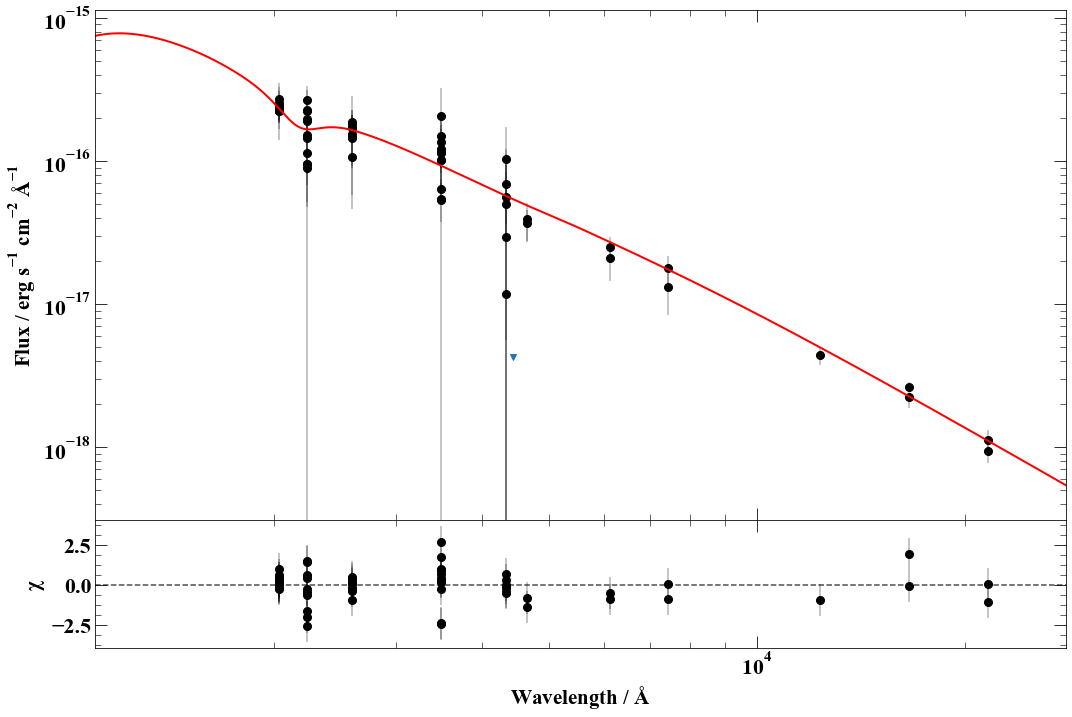

In [4]:
xo = np.arange(850,30000,1.)


def power_law(pars,x, data = None, sigma=None):
    norm = pars['norm'] 
    lam = pars['lam']
    ebv = pars['ebv']
    
    model = cv.unred(x,10**(norm) *(x)**lam,-ebv)
    
    if data is None:
        return model
    if sigma is None:
        return data - model
    else:
        return (data - model)/sigma

p = lm.Parameters()
p.add('norm', value=-5.0)  # x(1) = alpha. the disk power law index
p.add('lam',  value=-2.5, min=-4,max=3 )   
p.add('ebv',  value=e_bv, min=0,max=6,vary=True )   


re = lm.minimize(power_law,p,args=(data['x'],data['y']),
                 kws={'sigma':data['y_err']},method="leastsq")
lm.report_fit(re)
fit = power_law(re.params,xo)
scale_fac = np.sqrt(re.chisqr/re.nfree)
#scale_fac = 1


fig3 = plt.figure(num='new',figsize=(15,11))
plt.clf()
ax1 = plt.subplot2grid((6,1),(0,0),rowspan=4)

plt.errorbar(data['x'],data['y'],yerr=data['y_err']*scale_fac,color='k',
             marker='None',ls='None',alpha=0.3,capsize=0)

plt.plot(data['x'],data['y'],'ko')
plt.loglog(nonposy='clip')
plt.xlim(1100,28000)
plt.plot(xo,fit,'r',lw=2)
plt.plot(4430.,4.305e-18,'v',ms=6)
print("Error Scaling: {0:10.3f}".format(scale_fac))

ax1.axes.xaxis.set_ticklabels([])
plt.ylabel(r'Flux / erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$')
ax2 = plt.subplot2grid((6,1),(4,0))


plt.errorbar(data['x'],re.residual/scale_fac,color='k',
             marker=None,capsize=0,alpha=0.3,yerr=1.0,ls="None")
plt.plot(data['x'],re.residual/scale_fac,'ko',ls="None")
plt.xlim(1100,28000)
plt.xscale('log')
plt.axhline(y=0,ls='--',color='k',alpha=0.7)
plt.xlabel(r'Wavelength / $\AA$')
plt.ylabel('$\chi$')

plt.tight_layout(h_pad=0.0)
plt.subplots_adjust(hspace=0)

plt.draw()

